In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Untuk deep learning (sesuai saran 1)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Untuk Word2Vec
from gensim.models import Word2Vec

# Load dataset
df = pd.read_csv('playstore_reviews.csv')

Jumlah data: 100000
Jumlah aplikasi: 10
Distribusi rating:
score
1    23448
2     4149
3     4640
4     6343
5    61420
Name: count, dtype: int64


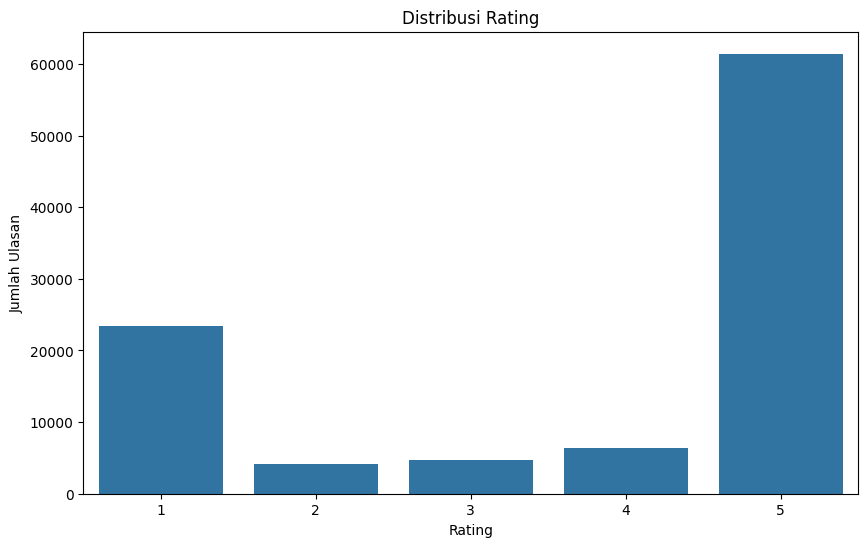

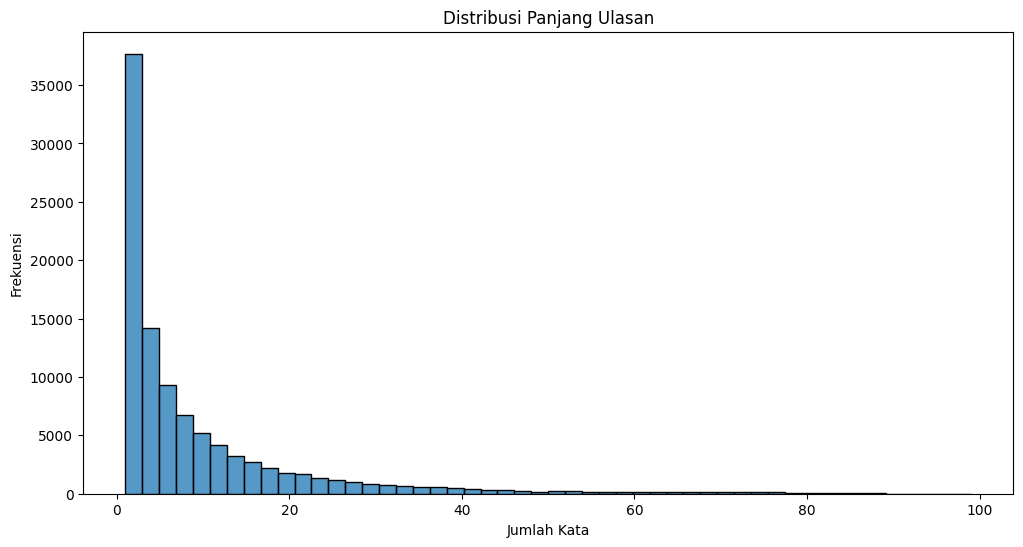

In [8]:
# Menampilkan informasi dasar dataset
print(f"Jumlah data: {len(df)}")
print(f"Jumlah aplikasi: {df['app_name'].nunique()}")
print(f"Distribusi rating:")
print(df['score'].value_counts().sort_index())

# Visualisasi distribusi rating
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=df)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

# Panjang teks ulasan
df['review_length'] = df['content'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='review_length', bins=50)
plt.title('Distribusi Panjang Ulasan')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

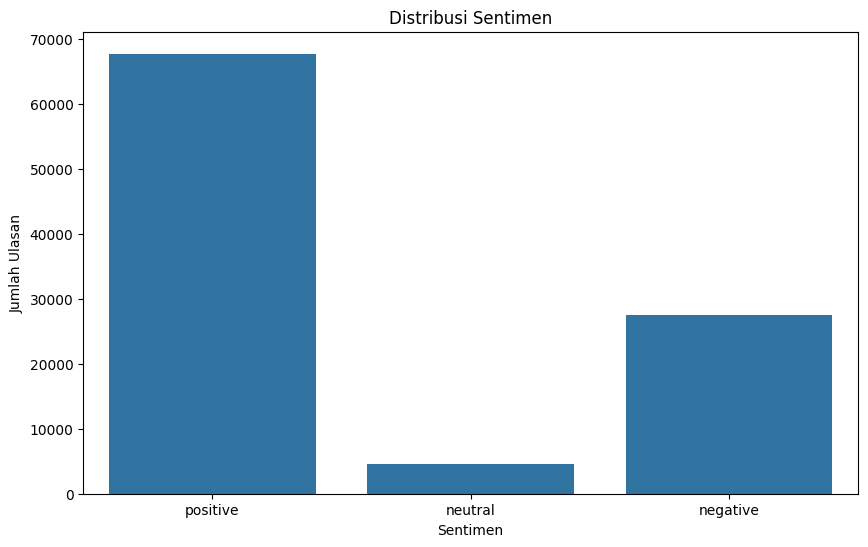

In [9]:
# Fungsi untuk membersihkan teks
def clean_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Hapus URL
        text = re.sub(r'http\S+', '', text)
        # Hapus tag HTML
        text = re.sub(r'<.*?>', '', text)
        # Hapus angka
        text = re.sub(r'\d+', '', text)
        # Hapus tanda baca
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Hapus whitespace berlebih
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Pelabelan data berdasarkan rating (3 kelas)
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

# Atau pelabelan dengan 5 kelas
def label_sentiment_5(rating):
    return f'rating_{int(rating)}'

# Terapkan preprocessing
df['clean_content'] = df['content'].apply(clean_text)
df['sentiment'] = df['score'].apply(label_sentiment)

# Melihat distribusi sentimen
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

# Split data
X = df['clean_content']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [12]:
import nltk
nltk.download('punkt')         # tokenizer
nltk.download('punkt_tab')     # kadang perlu untuk struktur tokenizer
nltk.download('averaged_perceptron_tagger')  # kalau nanti pakai POS tagging

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [13]:
# Tokenisasi untuk Word2Vec
nltk.download('punkt')
tokenized_train = [word_tokenize(text) for text in X_train]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi untuk membuat sentence vectors berdasarkan rata-rata word vectors
def get_sentence_vector(tokens, model, vector_size=100):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word]
            count += 1
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

# Convert sentences to vectors
X_train_w2v = np.array([get_sentence_vector(tokens, w2v_model) for tokens in tokenized_train])
tokenized_test = [word_tokenize(text) for text in X_test]
X_test_w2v = np.array([get_sentence_vector(tokens, w2v_model) for tokens in tokenized_test])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Accuracy (SVM + TF-IDF): 0.8666

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.85      0.80      5519
     neutral       0.00      0.00      0.00       928
    positive       0.91      0.93      0.92     13553

    accuracy                           0.87     20000
   macro avg       0.56      0.59      0.58     20000
weighted avg       0.83      0.87      0.85     20000



C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


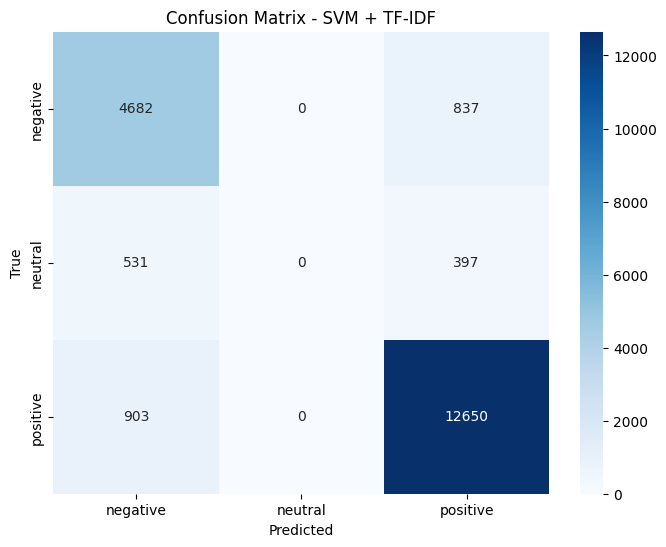

In [14]:
# Model SVM dengan TF-IDF
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Evaluasi
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM + TF-IDF): {accuracy_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues',
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title('Confusion Matrix - SVM + TF-IDF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy (RF + Word2Vec): 0.8420

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.84      0.77      5519
     neutral       0.17      0.01      0.01       928
    positive       0.91      0.90      0.90     13553

    accuracy                           0.84     20000
   macro avg       0.60      0.58      0.56     20000
weighted avg       0.82      0.84      0.83     20000



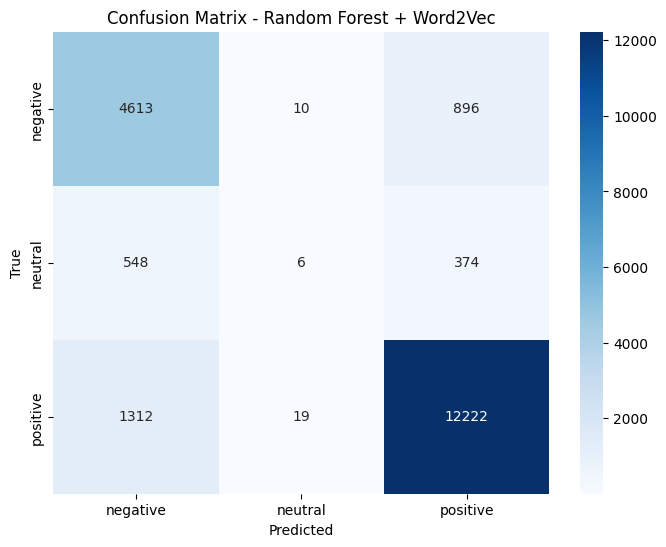

In [15]:
# Model Random Forest dengan Word2Vec
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_w2v, y_train)

# Evaluasi
y_pred_rf = rf_model.predict(X_test_w2v)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (RF + Word2Vec): {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - Random Forest + Word2Vec')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy (RF + TF-IDF, 70/30 split): 0.8590

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.86      0.79      8279
     neutral       0.20      0.01      0.01      1392
    positive       0.92      0.92      0.92     20329

    accuracy                           0.86     30000
   macro avg       0.62      0.60      0.57     30000
weighted avg       0.84      0.86      0.84     30000



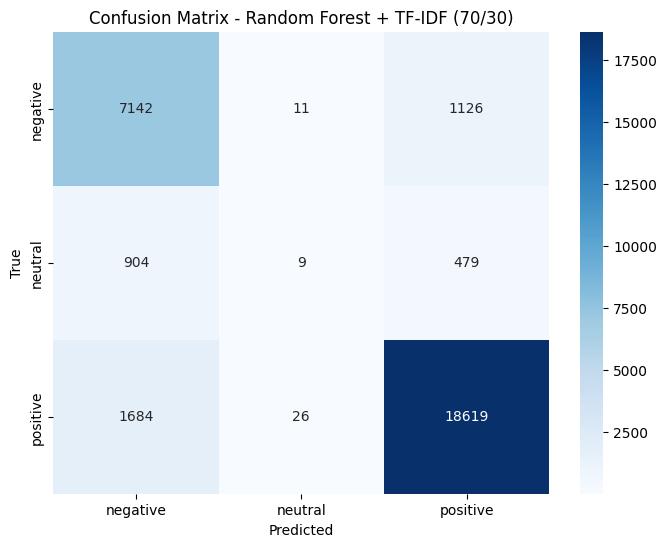

In [16]:
# Split data dengan ratio 70/30
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# TF-IDF Vectorizer
tfidf_vectorizer_70 = TfidfVectorizer(max_features=5000)
X_train_tfidf_70 = tfidf_vectorizer_70.fit_transform(X_train_70)
X_test_tfidf_30 = tfidf_vectorizer_70.transform(X_test_30)

# Model Random Forest dengan TF-IDF
rf_model_70 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_70.fit(X_train_tfidf_70, y_train_70)

# Evaluasi
y_pred_rf_70 = rf_model_70.predict(X_test_tfidf_30)
accuracy_rf_70 = accuracy_score(y_test_30, y_pred_rf_70)
print(f"Accuracy (RF + TF-IDF, 70/30 split): {accuracy_rf_70:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_30, y_pred_rf_70))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_30, y_pred_rf_70), annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model_70.classes_, yticklabels=rf_model_70.classes_)
plt.title('Confusion Matrix - Random Forest + TF-IDF (70/30)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

C:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 166s 140ms/step - accuracy: 0.8311 - loss: 0.4844 - val_accuracy: 0.8690 - val_loss: 0.3756
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 162s 144ms/step - accuracy: 0.8885 - loss: 0.3411 - val_accuracy: 0.8711 - val_loss: 0.3730
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 167s 149ms/step - accuracy: 0.8980 - loss: 0.3090 - val_accuracy: 0.8666 - val_loss: 0.3983
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 162s 144ms/step - accuracy: 0.9061 - loss: 0.2805 - val_accuracy: 0.8625 - val_loss: 0.4276
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 169s 150ms/step - accuracy: 0.9143 - loss: 0.2572 - val_accuracy: 0.8545 - val_loss: 0.4604
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8756 - loss: 0.3687
Deep Learning Model Accuracy: 0.8723
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step

Classification Report:


C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negative       0.75      0.89      0.82      5519
     neutral       0.00      0.00      0.00       928
    positive       0.93      0.92      0.93     13553

    accuracy                           0.87     20000
   macro avg       0.56      0.61      0.58     20000
weighted avg       0.84      0.87      0.85     20000



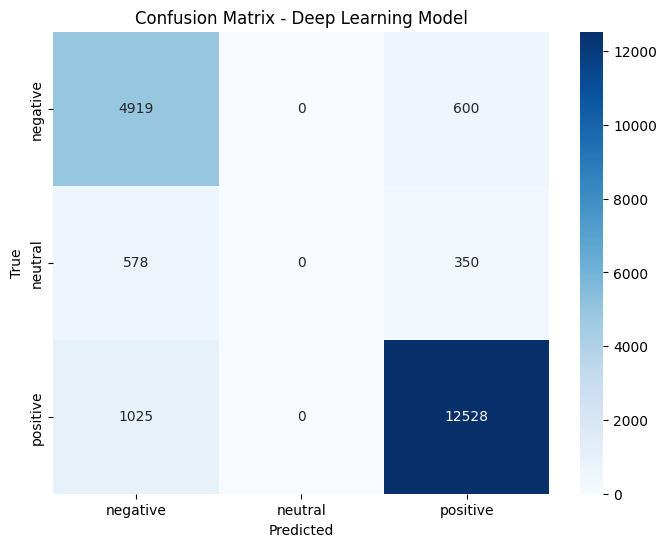

In [17]:
# Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# One-hot encode labels
label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_encoded = np.array([label_dict[label] for label in y_train])
y_test_encoded = np.array([label_dict[label] for label in y_test])

# Build model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train_encoded,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# Evaluate
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f"Deep Learning Model Accuracy: {accuracy:.4f}")

# Predictions
y_pred_dl = model.predict(X_test_pad)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)
y_pred_dl_labels = [list(label_dict.keys())[list(label_dict.values()).index(i)] for i in y_pred_dl_classes]
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dl_labels))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_dl_classes), annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_dict.keys()), yticklabels=list(label_dict.keys()))
plt.title('Confusion Matrix - Deep Learning Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
def predict_sentiment(text, model_type='deep_learning'):
    # Preprocess text
    cleaned_text = clean_text(text)
    
    if model_type == 'svm':
        # TF-IDF transformation
        text_tfidf = tfidf_vectorizer.transform([cleaned_text])
        # Predict
        prediction = svm_model.predict(text_tfidf)[0]
        return prediction
    
    elif model_type == 'random_forest_w2v':
        # Word2Vec transformation
        tokens = word_tokenize(cleaned_text)
        text_w2v = np.array([get_sentence_vector(tokens, w2v_model)])
        # Predict
        prediction = rf_model.predict(text_w2v)[0]
        return prediction
    
    elif model_type == 'random_forest_tfidf':
        # TF-IDF transformation
        text_tfidf = tfidf_vectorizer_70.transform([cleaned_text])
        # Predict
        prediction = rf_model_70.predict(text_tfidf)[0]
        return prediction
    
    elif model_type == 'deep_learning':
        # Sequence transformation
        text_seq = tokenizer.texts_to_sequences([cleaned_text])
        text_pad = pad_sequences(text_seq, maxlen=max_length, padding='post')
        # Predict
        prediction_prob = model.predict(text_pad)[0]
        prediction_class = np.argmax(prediction_prob)
        prediction_label = list(label_dict.keys())[list(label_dict.values()).index(prediction_class)]
        return prediction_label
    
    else:
        return "Invalid model type"

# Test the function with some examples
test_texts = [
    "Aplikasi ini sangat bagus, saya sangat suka!",
    "Aplikasi ini biasa saja, tidak ada yang istimewa.",
    "Aplikasi ini sangat buruk, banyak bug dan crash terus."
]

print("Predictions using Deep Learning model:")
for text in test_texts:
    prediction = predict_sentiment(text, model_type='deep_learning')
    print(f"Text: {text}")
    print(f"Sentiment: {prediction}\n")

print("\nPredictions using SVM model:")
for text in test_texts:
    prediction = predict_sentiment(text, model_type='svm')
    print(f"Text: {text}")
    print(f"Sentiment: {prediction}\n")

Predictions using Deep Learning model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Text: Aplikasi ini sangat bagus, saya sangat suka!
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Text: Aplikasi ini biasa saja, tidak ada yang istimewa.
Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Text: Aplikasi ini sangat buruk, banyak bug dan crash terus.
Sentiment: negative


Predictions using SVM model:
Text: Aplikasi ini sangat bagus, saya sangat suka!
Sentiment: positive

Text: Aplikasi ini biasa saja, tidak ada yang istimewa.
Sentiment: positive

Text: Aplikasi ini sangat buruk, banyak bug dan crash terus.
Sentiment: negative

